In [1]:
import xarray as xr
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import pandas as pd

import functions.data_wrangling as dw

In [2]:
main_path = '/home/links/ct715/data_storage/PAMIP/processed_monthly/mslp'
models = sorted(os.listdir(main_path))

# reanalysis data
jra55 = xr.open_dataset('/home/links/ct715/data_storage/reanalysis/jra55_daily/variables/mslp/slp_monthly_jra55_1958_2016.nc')
jra55 = jra55.mean('lon')
jra55['slp'] = jra55['slp'] / 100 

# PAMIP models
mslp = {}
for model in models:
    
    # open datasets and run data checker
    file_path = os.path.join(main_path, model, '*.nc')
    ds = xr.open_mfdataset(file_path, concat_dim='ens_ax', combine='nested')
    
    # take DJF mean
    ds = ds.mean('lon')
    
    # take ensemble mean
    ds = ds.mean(('time'))
        
    ds['psl'] = ds['psl'] / 100  # convert Pa to hPa
    
    mslp[model] = ds
    
mslp['JRA55'] = jra55.rename({'slp': 'psl'})


In [ ]:
def calculate_aao_indices(psl):
    
    # Use nearest grid point to −40° and −65° latitude
    lat40 = psl.lat.sel(lat=-40, method="nearest")
    lat65 = psl.lat.sel(lat=-65, method="nearest")
    p40 = psl.sel(lat=lat40)   # (time) hPa
    p65 = psl.sel(lat=lat65)   # (time) hPa

    # aaoI is the difference
    aaoi = p40 - p65
    return aaoi.load()


aao_indices = {}
for model_name, ds in mslp.items():
    aao_indices[model_name] = calculate_aao_indices(ds.psl)

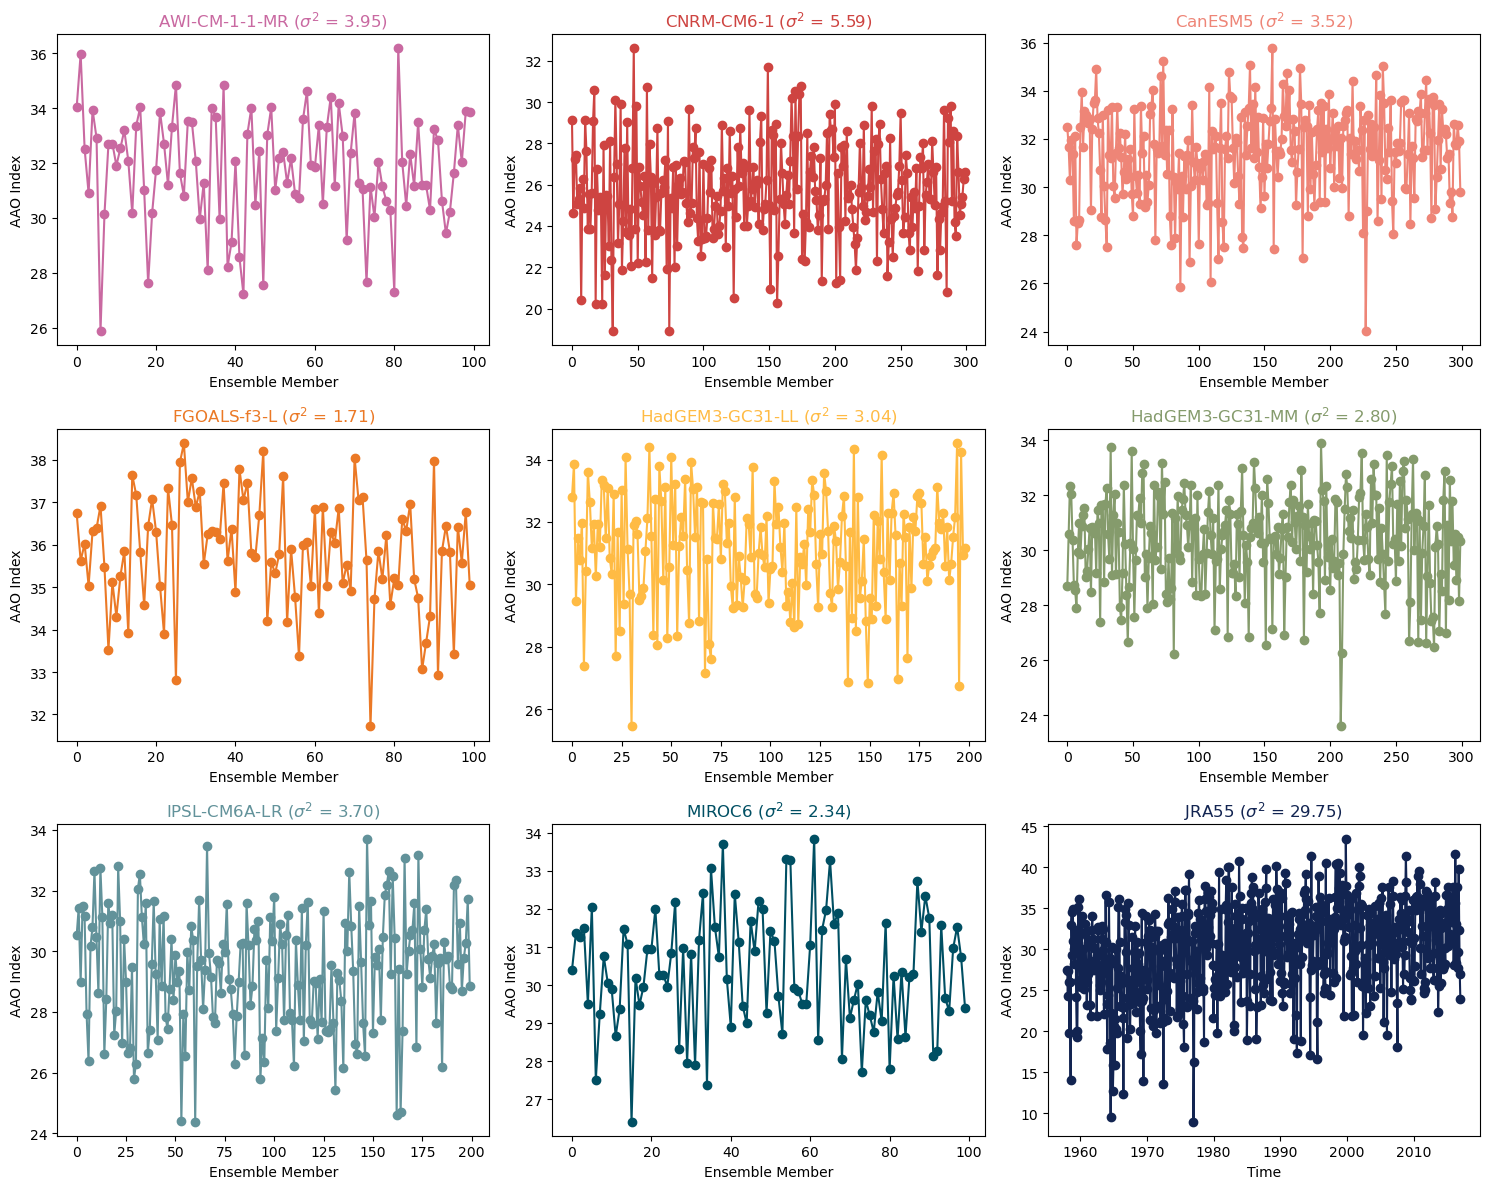

In [ ]:
from pypalettes import load_cmap
cmap = load_cmap("Cross")
# Define color palette
color_list = cmap.colors
model_colors = {}


models = list(aao_indices.keys())
n_models = len(models)
cols = 3
rows_grid = int(np.ceil(n_models / cols))


fig, axs = plt.subplots(rows_grid, cols, figsize=(cols * 5, rows_grid * 4))
axs = axs.flatten()

# Assign colors to each model
for i, model in enumerate(models):
    model_colors[model] = color_list[i % len(color_list)]

variance_info = []

for i, model in enumerate(models):
    ax = axs[i]
    aao_data = aao_indices[model]
    
    # X-axis and bar width
    if model == 'JRA55':
        time = aao_data['time']
        width= time[1] - time[0]  # Calculate width based on time intervals
    else:
        time = aao_data['ens_ax']
        width = 1

    # Variance
    variance = float(aao_data.var())
    variance_info.append({'model': model, 'variance': np.round(variance, 2)})

    # Bar color: single color per model
    color = model_colors[model]
    
    # Plot
    ax.plot(time, aao_data, color=color, marker='o', linewidth=1.5)
    ax.set_xlabel("Time" if model == 'JRA55' else "Ensemble Member")
    ax.set_ylabel("AAO Index")
    ax.set_title(f"{model} ($\\sigma^2$ = {variance:.2f})", color=color)

# Remove unused axes
for ax in axs[len(models):]:
    fig.delaxes(ax)

fig.tight_layout()
plt.show()


In [ ]:
# Convert variance info to DataFrame
df_variance = pd.DataFrame(variance_info)

# # Optionally sort by model or variance
# df_variance = df_variance.sort_values(by='model')

# # Save to CSV
# output_dir = "./data/pamip_misc"  # or your desired directory
# os.makedirs(output_dir, exist_ok=True)
# csv_path = os.path.join(output_dir, "aao_variance_info.csv")
# df_variance.to_csv(csv_path, index=False)

# print(f"Saved variance information to {csv_path}")

# Standardised data

In [ ]:
def calculate_aao_indices_std(psl, standardise=False):
    
    # Use nearest grid point to −40° and −65° latitude
    lat40 = psl.lat.sel(lat=-40, method="nearest")
    lat65 = psl.lat.sel(lat=-65, method="nearest")
    p40 = psl.sel(lat=lat40)   # (time) hPa
    p65 = psl.sel(lat=lat65)   # (time) hPa
    
    # take difference
    aaoi = p40 - p65
    
    if standardise:
        if 'ens_ax' in ds.dims:
            aaoi = (aaoi - aaoi.mean(dim='ens_ax')) / aaoi.std(dim='ens_ax')
        else:
            aaoi = (aaoi - aaoi.mean(dim='time')) / aaoi.std(dim='time')

    return aaoi.load()

In [ ]:
aao_indices_std = {}
for model_name, ds in mslp.items():
    aao_indices_std[model_name] = calculate_aao_indices_std(ds.psl, standardise=True)

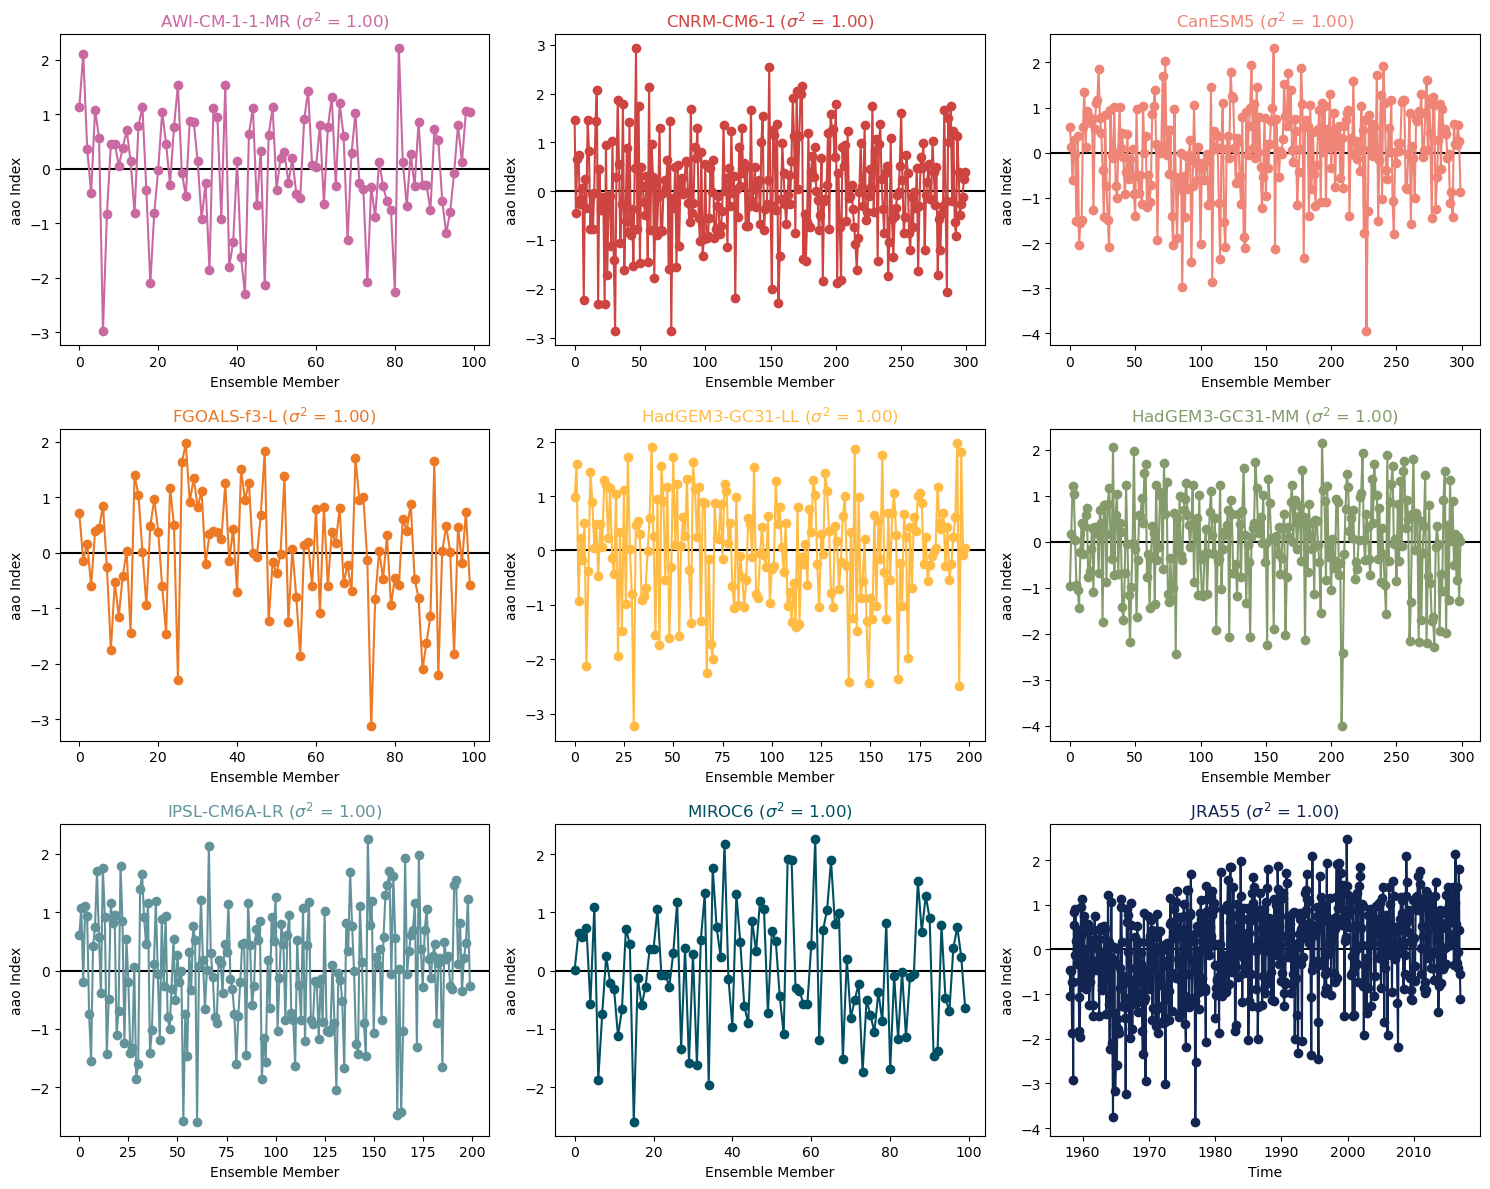

In [ ]:
models = list(aao_indices_std.keys())
n_models = len(models)
cols = 3
rows_grid = int(np.ceil(n_models / cols))


fig, axs = plt.subplots(rows_grid, cols, figsize=(cols * 5, rows_grid * 4))
axs = axs.flatten()

# Assign colors to each model
for i, model in enumerate(models):
    model_colors[model] = color_list[i % len(color_list)]

variance_info = []

for i, model in enumerate(models):
    ax = axs[i]
    aao_data = aao_indices_std[model]
    
    # X-axis and bar width
    if model == 'JRA55':
        time = aao_data['time']
        width= time[1] - time[0]  # Calculate width based on time intervals
    else:
        time = aao_data['ens_ax']
        width = 1

    # Variance
    variance = float(aao_data.var())
    variance_info.append({'model': model, 'variance': np.round(variance, 2)})

    # Bar color: single color per model
    color = model_colors[model]
    
    # Plot
    ax.plot(time, aao_data, color=color, marker='o', linewidth=1.5)
    ax.set_xlabel("Time" if model == 'JRA55' else "Ensemble Member")
    ax.set_ylabel("aao Index")
    ax.set_title(f"{model} ($\\sigma^2$ = {variance:.2f})", color=color)
    
    ax.axhline(y=0, color='k', zorder=-1)

# Remove unused axes
for ax in axs[len(models):]:
    fig.delaxes(ax)

fig.tight_layout()
plt.show()


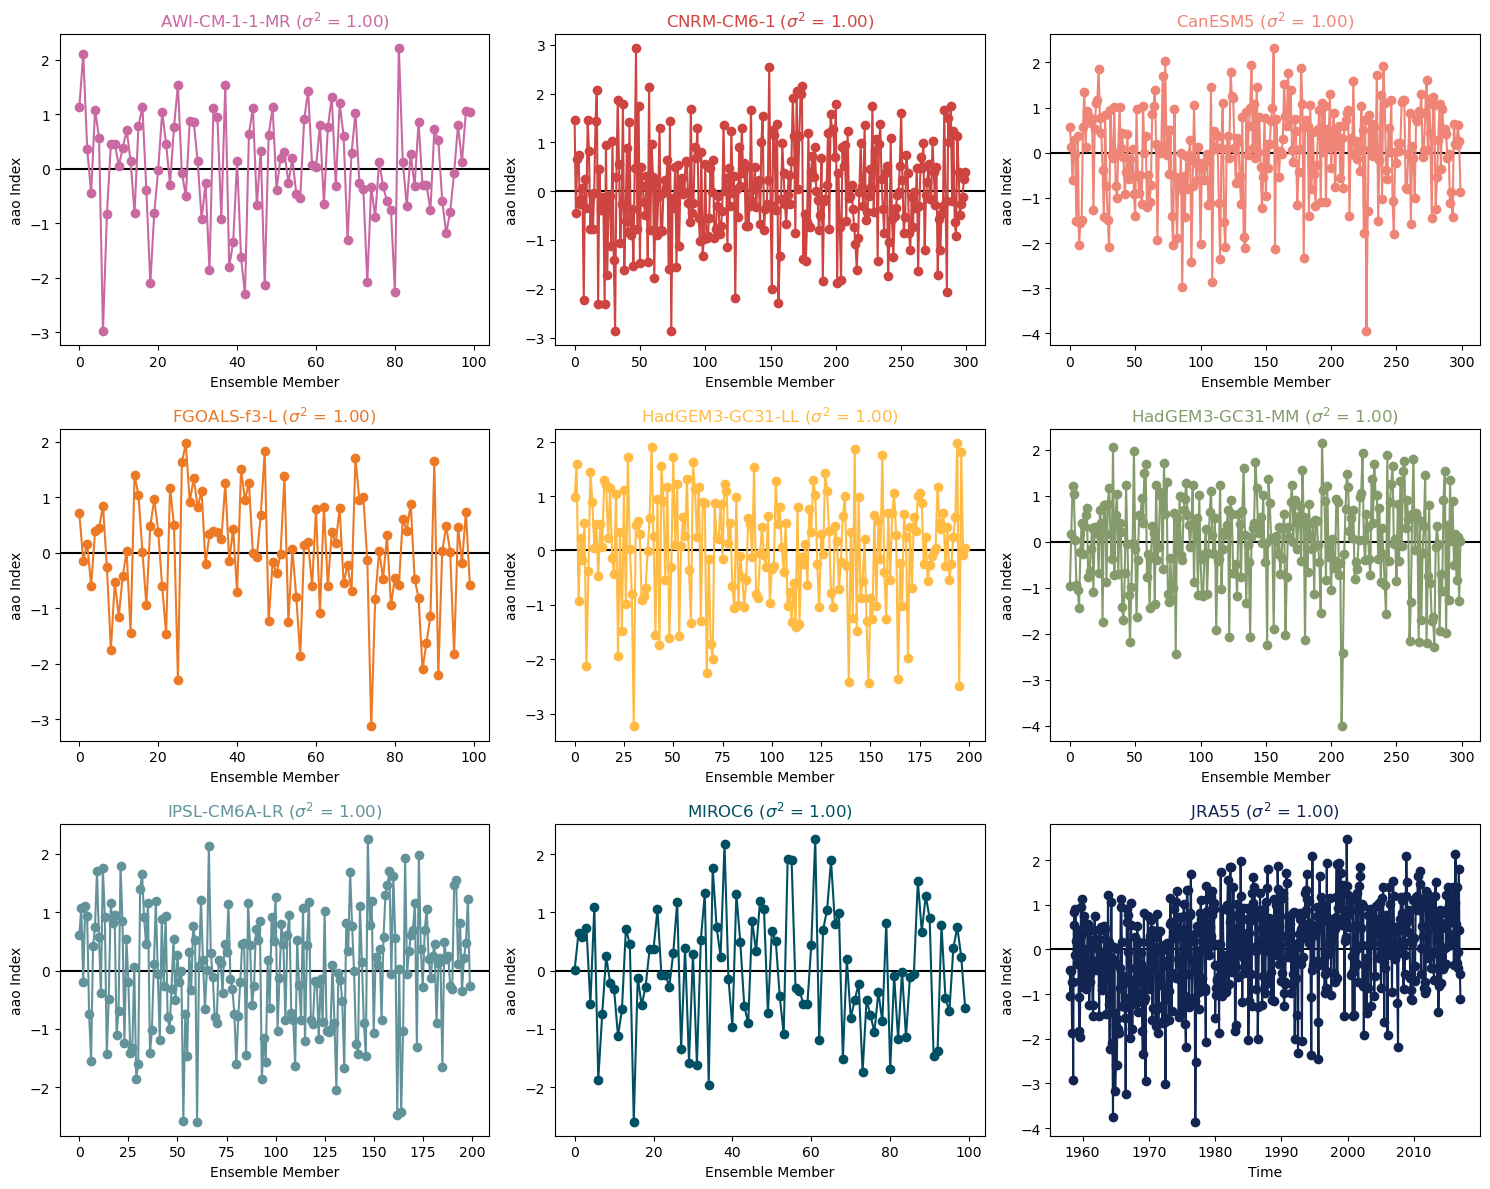

In [ ]:
models = list(aao_indices_std.keys())
n_models = len(models)
cols = 3
rows_grid = int(np.ceil(n_models / cols))


fig, axs = plt.subplots(rows_grid, cols, figsize=(cols * 5, rows_grid * 4))
axs = axs.flatten()

# Assign colors to each model
for i, model in enumerate(models):
    model_colors[model] = color_list[i % len(color_list)]

variance_info = []

for i, model in enumerate(models):
    ax = axs[i]
    aao_data = aao_indices_std[model]
    
    # X-axis and bar width
    if model == 'JRA55':
        time = aao_data['time']
        width= time[1] - time[0]  # Calculate width based on time intervals
    else:
        time = aao_data['ens_ax']
        width = 1

    # Variance
    variance = float(aao_data.var())
    variance_info.append({'model': model, 'variance': np.round(variance, 2)})

    # Bar color: single color per model
    color = model_colors[model]
    
    # Plot
    ax.plot(time, aao_data, color=color, marker='o', linewidth=1.5)
    ax.set_xlabel("Time" if model == 'JRA55' else "Ensemble Member")
    ax.set_ylabel("aao Index")
    ax.set_title(f"{model} ($\\sigma^2$ = {variance:.2f})", color=color)
    
    ax.axhline(y=0, color='k', zorder=-1)

# Remove unused axes
for ax in axs[len(models):]:
    fig.delaxes(ax)

fig.tight_layout()
plt.show()